### Import libraries

In [2]:
import numpy as np
from iminuit import Minuit
from classy import Class

import constants, functions

from functools import partial

import act_dr6_spt_lenslike as apslike
from joblib import Parallel, delayed

from time import time

from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from numba import njit

### Define axes

In [9]:
n_om = 50
n_s8 = 2
n_gamma = 2

om_min = .05
om_max = 1

s8_min = 0.4
s8_max = 1.2

gamma_min = -0.5
gamma_max = 2

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

### Define functions and values

In [4]:
z_data = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)

z_data_panth = np.asarray(constants.z_data_panth)
is_calibrator_panth = np.asarray(constants.is_calibrator_panth)
m_b_corr_panth = np.asarray(constants.m_b_corr_panth)
ceph_dist_panth = np.asarray(constants.ceph_dist_panth)
inv_cov_panth = np.asarray(constants.inv_cov_panth)
n_panth = constants.n_panth
c = constants.C

h=.674
omega_b=.0224
omega_cdm=.120
n_s=.965
tau_reio=.054

variant = 'act_baseline'
lens_only = True # use True if not combining with any primary CMB data
like_corrections = False # should be False if lens_only is True

data_dict = apslike.load_data(variant, lens_only=lens_only, like_corrections=like_corrections)

data = data_dict['data_binned_clkk']
binning_mat = data_dict['binmat_act']
cov_mat_inv = data_dict['cinv']

binmat = data_dict['binmat_act']
clkk_data = data_dict['data_binned_clkk']
cinv = data_dict['cinv']

def find_As_for_sigma8(sigma8_target, h=0.674, omega_b=0.0224, omega_cdm=0.12, n_s=0.965, tau_reio=0.054, 
                       As_min=1e-12, As_max=5e-9, tol=1e-3, max_iter=30):
    """ Dichotomy to find As s.a. sigma8 = sigma8_target.

    Args:
        sigma8_target (int, optional): Defaults to 1.
        h (float, optional): Defaults to 0.674.
        omega_b (float, optional): Defaults to 0.0224.
        omega_cdm (float, optional): Defaults to 0.12.
        n_s (float, optional): Defaults to 0.965.
        tau_reio (float, optional): Defaults to 0.054.
        As_min (_type_, optional): Defaults to 1e-12.
        As_max (_type_, optional): Defaults to 5e-9.
        tol (_type_, optional): Defaults to 1e-3.
        max_iter (int, optional): Defaults to 30.
    """
    def sigma8_for_As(As):
        params = {
            'output': 'lCl, mPk',
            'l_max_scalars': 3000,
            'h': h,
            'omega_b': omega_b,
            'omega_cdm': omega_cdm,
            'n_s': n_s,
            'A_s': As,
            'tau_reio': tau_reio
        }
        
        cosmo = Class()
        cosmo.set(params)
        cosmo.compute()
        sigma8 = cosmo.sigma8()
        cosmo.struct_cleanup()
        cosmo.empty()
        
        return sigma8

    for i in range(max_iter):
        As_mid = 0.5 * (As_min + As_max)
        sigma8_mid = sigma8_for_As(As_mid)

        if abs(sigma8_mid - sigma8_target) < tol:
            return As_mid 

        if sigma8_mid > sigma8_target:
            As_max = As_mid
        else:
            As_min = As_mid

kappa = find_As_for_sigma8(sigma8_target=1, tol=1e-4, max_iter=100)
print("Value kappa :", kappa)

A_s_0 = kappa * (.811**2)
A_s_min, A_s_max = kappa * (s8_min**2), kappa * (s8_max**2)

def get_clkk(A_s):    

    params = {
        'output': 'lCl',
        'l_max_scalars': 3001,
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'n_s': n_s,
        'A_s': A_s,
        'tau_reio': tau_reio,
    }
    
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    cl = cosmo.raw_cl()
    ell = cl['ell']
    clpp = cl['pp']

    clkk = (ell**2 * (ell + 1)**2) / 4 * clpp
    
    mask = (ell >= 2)
    ell = ell[mask]
    return clkk[mask]

@njit
def chi2_lensing(clkk_th, clkk_data, binmat, cinv):
    clkk_th_binned = binmat @ clkk_th
    delta = clkk_th_binned - clkk_data
    return delta.T @ cinv @ delta

@njit
def chi2_rsd_panth_act(z_data, fs8_data, fs8_err_plus, fs8_err_minus, n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega, sigma, gamma, H0, M, c, clkk_th):
    return chi2_lensing(clkk_th, clkk_data, binmat, cinv)

def chi2_rsd_panth_act_free_omega(z_data, fs8_data, fs8_err_plus, fs8_err_minus, n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega, sigma, gamma, H0, M, c):
    clkk_th = get_clkk(kappa * (omega**2))
    return chi2_lensing(clkk_th, clkk_data, binmat, cinv)

chi2_func = partial(
    chi2_rsd_panth_act,
    z_data,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    n_panth,
    z_data_panth,
    is_calibrator_panth,
    m_b_corr_panth,
    ceph_dist_panth,
    inv_cov_panth
)

chi2_func_free_omega = partial(
    chi2_rsd_panth_act_free_omega,
    z_data,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    n_panth,
    z_data_panth,
    is_calibrator_panth,
    m_b_corr_panth,
    ceph_dist_panth,
    inv_cov_panth
)

Loading ACT DR6 lensing likelihood v1.2...


/home/vicpabo/Documents/Projects/Stage-irap/programs/virtual_env/lib/python3.13/site-packages/act_dr6_spt_lenslike/act_dr6_spt_lenslike.py:500: UserWarning: Hartlap correction to cinv: 0.9861635220125786
  warnings.warn(f"Hartlap correction to cinv: {hartlap_correction}")


Value kappa : 3.1009658203125e-09


### Define Chi2 functions

In [5]:
from time import time

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    clkk_th = get_clkk(kappa * (omega**2))

    def chi2_for_minuit(omega, sigma, gamma, H0, M, c):
        return chi2_func(omega, sigma, gamma, H0, M, c, clkk_th)

    minimizer = Minuit(chi2_for_minuit, omega=omega, sigma=sigma, gamma=0.55, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    clkk_th = get_clkk(kappa * (omega**2))

    def chi2_for_minuit(omega, sigma, gamma, H0, M, c):
        return chi2_func(omega, sigma, gamma, H0, M, c, clkk_th)

    minimizer = Minuit(chi2_for_minuit, omega=omega, gamma=gamma, sigma=0.7, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, H0 = 73.4, M=-19.25, c=constants.C)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.fixed["c"] = True
    minimizer.migrad()
    return minimizer.fval

### Calculation of Chi2s

In [10]:
t = time()
chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
t = time() - t
print("chi2_grid1 calculated in", int(t//60), "min", round(t%60,1), "s.")


t = time()
chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, chi2_func) for omega in omega_vals for gamma in gamma_vals)
chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
t = time() - t
print("chi2_grid2 calculated in", int(t//60), "min", round(t%60,1), "s.")


chi2_grid1 calculated in 0 min 25.4 s.
chi2_grid2 calculated in 0 min 25.0 s.


### Plot

(0.4, 1.0)
Incertitude $\sigma_8$ : xmin = 0.40, xmax = 1.20 : (+0.0, -0.8)
Incertitude $\Omega_m$ : ymin = 1.00, ymax = 1.00 : (+0.0, -0.0)



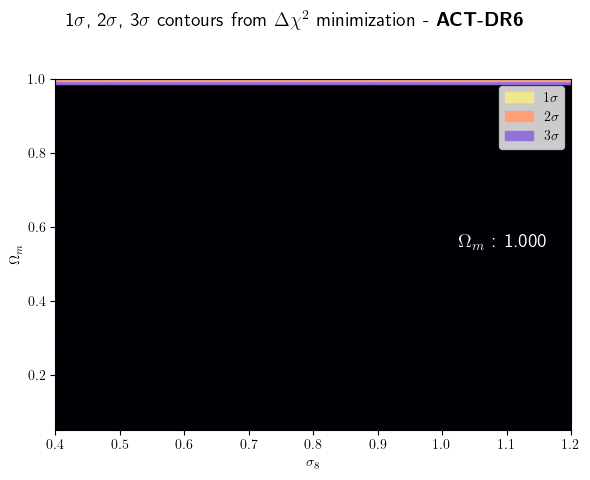

(-0.5, 1.0)
Incertitude $\gamma$ : xmin = -0.50, xmax = 2.00 : (+0.0, -2.5)
Incertitude $\Omega_m$ : ymin = 1.00, ymax = 1.00 : (+0.0, -0.0)



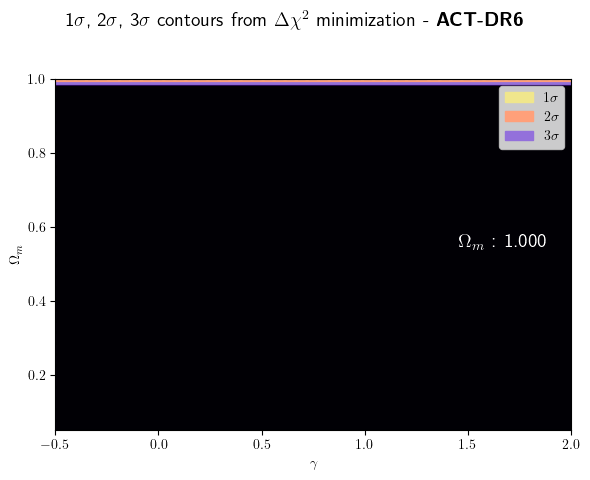

In [12]:
def display_one_chi2(chi2_grid, ax, axis):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$'),
        (r'$\gamma$', r'$\Omega_m$'),
        (r'$\gamma$', r'$\sigma_8$')
    ]

    sigma_vals = np.asarray(np.linspace(s8_min, s8_max, chi2_grid.shape[1]))
    omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
    gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, chi2_grid.shape[1]))

    if axis == 0:
        X, Y = np.meshgrid(sigma_vals, omega_vals)
    elif axis == 1:
        X, Y = np.meshgrid(gamma_vals, omega_vals)
    elif axis == 2:
        X, Y = np.meshgrid(gamma_vals, sigma_vals)

    chi2_min = np.min(chi2_grid)
    delta_chi2 = chi2_grid - chi2_min
    delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])

    cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
    for level, color in zip(levels, colors):
        cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

        if level == 2.3:
            mask = delta_chi2 <= level
            x_coords = X[mask]
            y_coords = Y[mask]

            xmin, xmax = np.min(x_coords), np.max(x_coords)
            ymin, ymax = np.min(y_coords), np.max(y_coords)

    legend_handles = [
        Patch(color='khaki', label=r'$1\sigma$'),
        Patch(color='lightsalmon', label=r'$2\sigma$'),
        Patch(color='mediumpurple', label=r'$3\sigma$')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
    x_min = X[min_idx]
    y_min = Y[min_idx]
    ax.axhline(y_min, color='indigo', linestyle='--')
    ax.axvline(x_min, color='indigo', linestyle='--')

    print((x_min, y_min))
    xlabel, ylabel = axes_titles[axis]
    print(f"Incertitude {xlabel} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
    print(f"Incertitude {ylabel} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

    latex_text = fr"{ylabel} : {y_min:.3f}"
    ax.text(0.78, 0.56, latex_text, transform=ax.transAxes, color="white", fontsize=14,
            verticalalignment='top', horizontalalignment='left')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_facecolor('black')

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rcParams.update({"text.usetex": True})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{ACT-DR6}$", fontsize=14)
display_one_chi2(chi2_grid1, ax, axis=0)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.rcParams.update({"text.usetex": True})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{ACT-DR6}$", fontsize=14)
display_one_chi2(chi2_grid2, ax, axis=1)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
